In [1]:
import autokeras as ak
import matplotlib.pyplot as plt
import matplotlib.gridspec as mpl
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.autograd import Function
from tensorflow.keras.models import load_model
import tensorflow as tf
import medmnist
from medmnist import INFO, Evaluator
import torchvision.transforms as trn
import torchvision.transforms.functional as trn_F
import cv2
from sklearn.metrics import accuracy_score, f1_score

In [2]:
data_flag = 'pneumoniamnist'
download = True

#NUM_EPOCHS = 3
#BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
validation_dataset = DataClass(split = 'val', transform = data_transform, download = download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

Using downloaded and verified file: C:\Users\Egg\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\Egg\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\Egg\.medmnist\pneumoniamnist.npz


In [3]:
x_train = train_dataset.imgs
x_val = validation_dataset.imgs
x_test = test_dataset.imgs

In [4]:
y_train = train_dataset.labels.reshape((len(train_dataset.labels),))
y_val   = validation_dataset.labels.reshape((len(validation_dataset.labels),))
y_test  = test_dataset.labels.reshape((len(test_dataset.labels),))

In [5]:
proportion = [0.2, 0.4, 0.6, 0.8, 1]
num_train  = len(y_train)
num_test   = len(y_test)
num_iter   = 1000
perturbs   = ['noise', 'contrast', 'rotate', 'tilt', 'blur']

In [6]:
def rotate(img, deg):
    z = trn.CenterCrop(28)(trn_F.affine(Image.fromarray(img), angle=deg-15, translate=(0, 0), scale=1., shear=0, resample=Image.BILINEAR))
    return z

In [7]:
def disk(radius, alias_blur=0.1, dtype=np.float32):
    if radius <= 8:
        L = np.arange(-8, 8 + 1)
        ksize = (3, 3)
    else:
        L = np.arange(-radius, radius + 1)
        ksize = (5, 5)
    X, Y = np.meshgrid(L, L)
    aliased_disk = np.array((X ** 2 + Y ** 2) <= radius ** 2, dtype=dtype)
    aliased_disk /= np.sum(aliased_disk)

    # supersample disk to antialias
    return cv2.GaussianBlur(aliased_disk, ksize=ksize, sigmaX=alias_blur)

In [8]:
def tilt(img, deg):
    x = np.array(img)
    h, w = x.shape[0:2]
    phi, theta = np.deg2rad(deg-15), np.deg2rad(deg-15)
    f = np.sqrt(w**2+h**2)
    P1 = np.array([[1,0,-w/2], [0,1,-h/2], [0,0,1], [0,0,1]])
    RX = np.array([[1,0,0,0], [0, np.cos(theta), -np.sin(theta), 0],
                  [0, np.sin(theta), np.cos(theta), 0], [0, 0, 0, 1]])
    RY = np.array([[np.cos(phi), 0, -np.sin(phi), 0], [0,1,0,0],
                  [np.sin(phi), 0, np.cos(phi), 0], [0, 0, 0, 1]])
    T = np.array([[1, 0, 0, 0], [0, 1, 0, 0],
                   [0, 0, 1, f], [0, 0, 0, 1]])
    P2 = np.array([[f, 0, w / 2, 0], [0, f, h / 2, 0], [0, 0, 1, 0]])
    mat = P2 @ T @ RX @ RY @ P1
    z = trn.CenterCrop(28)(Image.fromarray(cv2.warpPerspective(x, mat, (w, h))))
    return z

In [9]:
def contrast(img, factor, dim = 2):
    
    if dim == 3:
        num = img.shape[0]
        temp = np.zeros((num,img.shape[1], img.shape[2]))
        for i in range(num):
            tempi = img[i,:,:]
            im = Image.fromarray(tempi)
            enhancer = ImageEnhance.Contrast(im)
            im_output = enhancer.enhance(factor)
            im_array = np.asarray(im_output)
            temp[i,:,:] = im_array
        return temp
    else:
        im = Image.fromarray(img)
        enhancer = ImageEnhance.Contrast(im)
        im_output = enhancer.enhance(factor)
        im_array = np.asarray(im_output)
        return im_array

In [10]:
def defocus_blur(x, severity=1):
    c = [(3, 0.1), (4, 0.5), (6, 0.5), (8, 0.5), (10, 0.5)][severity - 1]

    x = np.array(x) / 255.
    kernel = disk(radius=c[0], alias_blur=c[1])

    channels = []
    channels.append(cv2.filter2D(x[:, :], -1, kernel))
    channels = np.array(channels).transpose((1, 2, 0))  # 3x224x224 -> 224x224x3
    output = np.clip(channels, 0, 1) * 255
    output = output.reshape((28,28))
    return output

In [11]:
def gaussian_noise(x, c):
    #c =[0.02, 0.04, 0.06, 0.08, 0.1][severity - 1]
    
    x = np.array(x)/255
    np.random.seed(2)
    x = np.clip(x+ np.random.normal(size = x.shape, scale = c), 0, 1 * 255)
    return x.astype(np.float32)

In [12]:
def plot(img):
    plt.figure(figsize = (2,2))
    plt.imshow(img, cmap = "gray")
    plt.show()

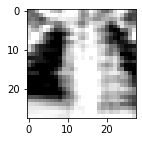

In [13]:
from PIL import Image, ImageEnhance
img = x_test[1]
im = Image.fromarray(img)
enhancer = ImageEnhance.Contrast(im)

factor = 3 #gives original image
im_output = enhancer.enhance(factor)
plt.figure(figsize = (2,2))
plt.imshow(im_output, cmap = "gray")
plt.show()
#im_output.save('original-image.png')

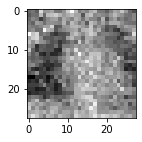

In [14]:
plot(gaussian_noise(img, 0.08))

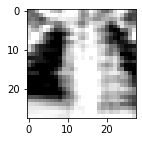

In [15]:
test_img = contrast(img,3)
plot(test_img)

In [16]:
def perturb_data(samples, idx_corrupt, variant):
    
    num_total = samples.shape[0]
    temp_set = np.zeros((samples.shape))
    img_shape = samples[0].shape
    
    if variant == 'noise':
        for k in range(num_total):
            img = samples[k]
            if k in idx_corrupt:
                temp = gaussian_noise(img, 0.08)
                temp_set[k] = temp*255
            else:
                temp = np.copy(img)
                temp_set[k] = temp
                
    if variant == 'contrast':
        for k in range(num_total):
            img = samples[k]
            if k in idx_corrupt:
                temp = contrast(img, 3)
                temp_set[k] = temp
            else:
                temp = np.copy(img)
                temp_set[k] = temp
    
    if variant == 'tilt':
        for k in range(num_total):
            img = samples[k]
            np.random.seed(k**2)
            angle = np.random.randint(0, high = 90)
            
            if k in idx_corrupt:
                temp = tilt(img, angle)
                temp_set[k] = temp
            else:
                temp = np.copy(img)
                temp_set[k] = temp
    
    if variant == 'blur':
        for k in range(num_total):
            img = samples[k]
            if k in idx_corrupt:
                temp = defocus_blur(img, severity = 1).reshape((28,28))
                temp_set[k] = temp
            else:
                temp = np.copy(img)
                temp_set[k] = temp
    
    if variant == 'rotate':
        for k in range(num_total):
            img = samples[k]
            np.random.seed(k)
            angle = np.random.randint(-90, high = 90)
            if k in idx_corrupt:
                temp        = rotate(img, angle)
                temp_set[k] = temp
            else:
                temp = np.copy(img)
                temp_set[k] = temp

    return temp_set

In [17]:
def create_perturbed_models(iterable_1, iterable_2, initialstring, training_sets):
    models_to_export = {}
    for i in range(len(iterable_1)):
        label_1 = iterable_1[i]
        model_holder = []
        for j in range(len(iterable_2)):
            p = iterable_2[j]
        
            train_set = training_sets[label_1][j]
            temp_ = []
            temp_ = load_model(initialstring, custom_objects = ak.CUSTOM_OBJECTS)
        
            weights = temp_.get_weights()
            np.random.seed(12345)
            weights = [np.random.permutation(w.flat).reshape(w.shape) for w in weights]
            temp_.set_weights(weights)
            temp_.fit(train_set, y_train, epochs = 5, batch_size = 8)
        
        try:
            temp_.save(initialstring+str(label_1)+"_"+str(p), save_format = "tf")
        except Exception:
            temp_.save(initialstring+str(label_1)+"_"+str(p)+".h5")
        model_holder.append(temp_)
        models_to_export[label_1] = model_holder
    return models_to_export

In [18]:
def load_dict_models_premade(iterable_1, iterable_2, initialstring, suffix = "ReRun"):
    imported_dict = {}
    for i in range(len(iterable_1)):
        source = iterable_1[i]
        if source == 'noise':
            suffix = "ReRun3"
        else:
            suffix = "ReRun"
        mod_list = []
        for j in range(len(iterable_2)):
            p = iterable_2[j]
            temp_model = load_model(initialstring + str(source) + "_" + str(p)+str(suffix), custom_objects = ak.CUSTOM_OBJECTS)
            mod_list.append(temp_model)
        imported_dict[source] = mod_list
    return imported_dict

In [19]:
from tqdm import tqdm
num_models = 10
pmodel_list = []
omodel_list = []
amodel_list = []
for i in tqdm(range(num_models)):
    pmodel_list.append(load_dict_models_premade(iterable_1 = perturbs, iterable_2 = proportion, initialstring = "MODEL_"+str(i)+"_XRAY_"))
    omodel_list.append(load_model("MODEL_"+str(i)+"_XRAY", custom_objects = ak.CUSTOM_OBJECTS))
    amodel_list.append(load_model("MODEL_"+str(i)+"_XRAY_ADV", custom_objects = ak.CUSTOM_OBJECTS))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:15<00:00, 13.51s/it]


In [20]:
%%time
temp = load_model("MODEL_0_XRAY_noise_0.2ReRun", custom_objects = ak.CUSTOM_OBJECTS)

Wall time: 510 ms


In [21]:
%%time
results = temp.predict(x_test)

Wall time: 729 ms


In [22]:
%%time
results = pmodel_list[0]['noise'][0].predict(x_test)

Wall time: 886 ms


In [23]:
#Get Performance on Clean Test Set
from sklearn.metrics import accuracy_score, f1_score

A = []
F = []
default_mods = []
mods = pmodel_list
mod_ = omodel_list
props_ = [0, 0.2, 0.4, 0.6, 0.8, 1]
for k in tqdm(range(len(mods))):
    accs_on_clean = np.zeros((len(perturbs), len(props_)))
    f1_on_clean   = np.zeros((len(perturbs), len(props_)))
    clean_mod = mod_[k]
    mod_dict = mods[k]
    for i in range(len(perturbs)):
        perturb_source = perturbs[i]
        for j in range(len(props_)):
            p = props_[j]
            
            if p == 0:
                clf = clean_mod
            else:
                clf = mod_dict[perturb_source][j-1]
        
            preds = clf.predict(x_test).round()
        
            accs_on_clean[i,j] = accuracy_score(y_test, preds)
            f1_on_clean[i,j]   = f1_score(y_test, preds)
    A.append(accs_on_clean)
    F.append(f1_on_clean)

  0%|                                                                                           | 0/10 [00:11<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
plt.figure()
r = np.arange(6)
rvec = [-0.2, -0.1, 0, 0.1, 0.2, 0.3]
for j in range(len(perturbs)):
    perturb_source = perturbs[j]
    plt.bar(r+rvec[j], 1-avgs_on_clean[j,:], 0.1, label = perturb_source)
plt.xticks(ticks = r, labels = np.array(props_)*100)
plt.xlabel("Percent Training Data Perturbed")
plt.ylabel("Error Rate on Clean Test Set")
#plt.title("Performance on Unperturbed Data")
plt.legend()
plt.savefig('CleanTestAcc_Avg_Test.png')

In [24]:
#Centralized MC Creation

proportion = [0.2, 0.4, 0.6, 0.8, 1.0]
num_train  = len(y_train)
num_test   = len(y_test)
num_iter   = 200
perturbs   = ['noise', 'contrast', 'rotate', 'tilt', 'blur']
mc_sets = {}
for i in range(len(perturbs)):
    mc_test_sets = []
    perturb_source = perturbs[i]
    for j in range(len(proportion)):
        
        p = proportion[j]
        proplist = []
        for k in tqdm(range(num_iter)):
            
            np.random.seed(k)
            test_idx    =  np.random.choice(int(num_test), size = int(np.round(p*num_test)), replace = False)        
            mc_test = perturb_data(samples = x_test, idx_corrupt = test_idx, variant = perturb_source)
            proplist.append(mc_test)
            
        mc_test_sets.append(proplist)    
        
    mc_sets[perturb_source] = mc_test_sets
        

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]C:\Users\Egg\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1135: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. Please use 'interpolation' instead.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:26<00:00,  7.60it/s]


In [26]:
accs_clean = []
accs_pert  = []
accs_pert2  = []
accs_pert3  = []
accs_adv   = []

for m in range(len(pmodel_list)):
    
    acc_of_clean_clf = {}
    acc_of_pert_clf = {}
    acc_of_pert_clf2 = {}
    acc_of_pert_clf3 = {}
    acc_of_adv_clf = {}
    
    pmodels = pmodel_list[m]
    omodel = omodel_list[m]
    amodel = amodel_list[m]
    for i in range(len(perturbs)):
        results_clean = np.zeros((num_iter, len(proportion)))
        results_perturbed = np.zeros((num_iter, len(proportion)))
        results_perturbed2 = np.zeros((num_iter, len(proportion)))
        results_perturbed3 = np.zeros((num_iter, len(proportion)))
        results_adversarial = np.zeros((num_iter, len(proportion)))
        perturb_source = perturbs[i]
        
        for j in range(len(proportion)):
            p = proportion[j]
            

            for k in tqdm(range(num_iter)):
            
                clean_preds = omodel.predict(mc_sets[perturb_source][j][k]).round()
                pert_preds  = pmodels[perturb_source][0].predict(mc_sets[perturb_source][j][k]).round()
                pert_preds2 = pmodels[perturb_source][2].predict(mc_sets[perturb_source][j][k]).round()
                pert_preds3  = pmodels[perturb_source][4].predict(mc_sets[perturb_source][j][k]).round()
                adv_preds   = amodel.predict(mc_sets[perturb_source][j][k]).round()
            
                err_num = 1-accuracy_score(y_test, clean_preds)
                err_den = 1-accuracy_score(y_test, pert_preds)
                err_2 = 1-accuracy_score(y_test, pert_preds2)
                err_3 = 1-accuracy_score(y_test, pert_preds3)
                err_4 = 1-accuracy_score(y_test, adv_preds)
        
                results_clean[k,j] = err_num
                results_perturbed[k,j] = err_den
                results_perturbed2[k,j] = err_2
                results_perturbed3[k,j] = err_3
                results_adversarial[k,j] = err_4
            
        acc_of_clean_clf[perturb_source] = results_clean
        acc_of_pert_clf[perturb_source]  = results_perturbed
        acc_of_pert_clf2[perturb_source] = results_perturbed2
        acc_of_pert_clf3[perturb_source]  = results_perturbed3
        acc_of_adv_clf[perturb_source] = results_adversarial
    accs_clean.append(acc_of_clean_clf)
    accs_pert.append(acc_of_pert_clf)
    accs_pert2.append(acc_of_pert_clf2)
    accs_pert3.append(acc_of_pert_clf3)
    accs_adv.append(acc_of_adv_clf)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [14:38<00:00,  4.39s/it]


In [27]:
clean_avgs = {}
pert_avgs = {}
pert_avgs2 = {}
pert_avgs3 = {}
adv_avgs = {}
clean_stds = {}
pert_stds  = {}
pert_stds2 = {}
pert_stds3 = {}
adv_stds = {}
for j in perturbs:
    clean_avgs[j] = np.zeros((10,5))
    pert_avgs[j]  = np.zeros((10,5))
    pert_avgs2[j] = np.zeros((10,5))
    pert_avgs3[j] = np.zeros((10,5))
    adv_avgs[j] = np.zeros((10,5))
    clean_stds[j] = np.zeros((10,5))
    pert_stds[j]  = np.zeros((10,5))
    pert_stds2[j] = np.zeros((10,5))
    pert_stds3[j] = np.zeros((10,5))
    adv_stds[j] = np.zeros((10,5))
    for i in range(len(accs_clean)):
        clean_avgs[j][i,:] = np.mean(accs_clean[i][j], axis = 0)
        pert_avgs[j][i,:] = np.mean(accs_pert[i][j], axis = 0)
        pert_avgs2[j][i,:] = np.mean(accs_pert2[i][j], axis = 0)
        pert_avgs3[j][i,:] = np.mean(accs_pert3[i][j], axis = 0)
        adv_avgs[j][i,:] = np.mean(accs_adv[i][j], axis = 0)
        clean_stds[j][i,:] = np.std(accs_clean[i][j], axis = 0)
        pert_stds[j][i,:]  = np.std(accs_pert[i][j], axis = 0)
        pert_stds2[j][i,:] = np.std(accs_pert2[i][j], axis = 0)
        pert_stds3[j][i,:] = np.std(accs_pert3[i][j], axis = 0)
        adv_stds[j][i,:] = np.std(accs_adv[i][j], axis = 0)

<ipython-input-30-c81392234598>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[j].set_xticklabels([0,20,40,60,80,100])


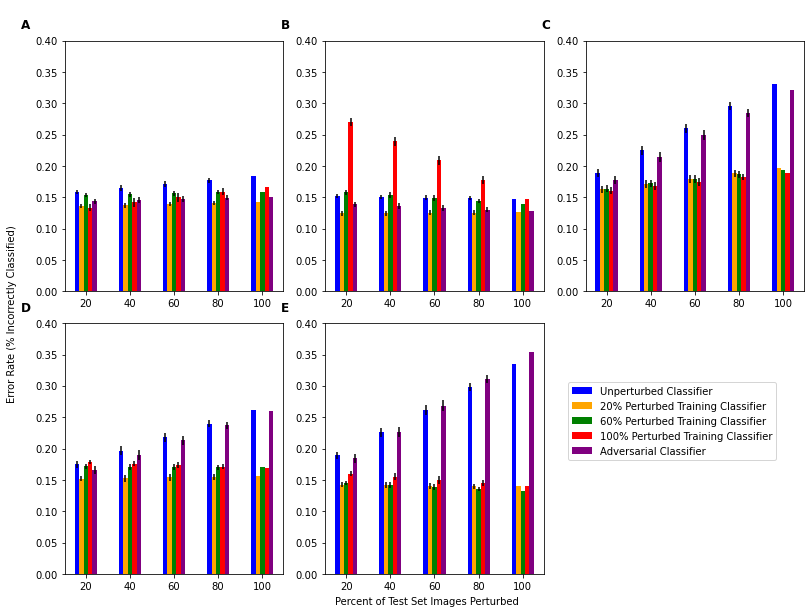

In [30]:
perturbs_capital = ['Noise', 'Contrast', 'Rotate', 'Tilt', 'Blur']
fig= plt.figure(figsize = (11,8))
#spec = mpl.GridSpec(ncols = 3, nrows = 2)
gs = fig.add_gridspec(2,3)
axs = [fig.add_subplot(gs[i]) for i in range(5)]
letters = ["A","B","C","D","E"]

fig.canvas.draw()

fig.text(0.5, 0, 'Percent of Test Set Images Perturbed', ha='center', va='center')
fig.text(-0.03, 0.5, 'Error Rate (% Incorrectly Classified)', va = 'center', rotation = 'vertical')
fig.tight_layout()
#fig.text(-0.04, 0.5, 'Error Rate (% Incorrectly Classified)', ha='center', va='center', rotation='vertical')
for ax, label in zip(axs, letters):
    bbox = ax.get_tightbbox(fig.canvas.get_renderer())
    fig.text(bbox.x0+10, bbox.y1+30, label, fontsize = 12, va = "top", ha = "left", fontweight = "bold", transform = None)
r = np.arange(5)
for j in range(len(perturbs)):
    p = perturbs[j]
    c = perturbs_capital[j]
    
    axs[j].bar(r - 0.2, np.mean(clean_avgs[p], axis = 0) , 0.1, yerr = np.mean(clean_stds[p], axis = 0),color = 'blue',label = 'Unperturbed Classifier')
    axs[j].bar(r - 0.1, np.mean(pert_avgs[p], axis = 0), 0.1, yerr = np.mean(pert_stds[p], axis = 0),color = 'orange',label = '20% Perturbed Training Classifier')
    axs[j].bar(r , np.mean(pert_avgs2[p], axis = 0), 0.1, yerr = np.mean(pert_stds2[p], axis = 0),color = 'green',label = '60% Perturbed Training Classifier')
    axs[j].bar(r + 0.1, np.mean(pert_avgs3[p], axis = 0), 0.1, yerr = np.mean(pert_stds3[p], axis = 0),color = 'red',label = '100% Perturbed Training Classifier')
    axs[j].bar(r + 0.2, np.mean(adv_avgs[p], axis = 0), 0.1, yerr = np.mean(adv_stds[p], axis = 0),color = 'purple',label = 'Adversarial Classifier')
    axs[j].set_xticklabels([0,20,40,60,80,100])
    axs[j].set_ylim((0,0.4))
handles, labels = axs[0].get_legend_handles_labels()

#fig.supylabel('Error Rate (% Incorrectly Classified)')
fig.legend(handles, labels, loc=(0.70,0.25))
fig.savefig('Full_Fig_Adv.png', bbox_inches = 'tight')
#fig.suptitle('Comparison of Unperturbed Classifier and 20% Perturbed Classifier Performance by Perturbation')

In [44]:
accs_clean = []
accs_pert  = []

for m in range(len(pmodel_list)):
    
    acc_of_clean_clf = {}
    acc_of_pert_clf = {}
    
    pmodels = pmodel_list[m]
    omodel = omodel_list[m]
    for i in range(len(perturbs)):
        results_clean = np.zeros((num_iter, len(proportion)))
        results_perturbed = np.zeros((num_iter, len(proportion)))
        
        perturb_source = perturbs[i]
        
        for j in range(len(proportion)):
            p = proportion[j]
            

            for k in tqdm(range(num_iter)):
            
                clean_preds = omodel.predict(mc_sets[perturb_source][j][k]).round()
                pert_preds  = pmodels[perturb_source][0].predict(mc_sets[perturb_source][j][k]).round()
            
                err_num = 1-accuracy_score(y_test, clean_preds)
                err_den = 1-accuracy_score(y_test, pert_preds)
        
                results_clean[k,j] = err_num
                results_perturbed[k,j] = err_den
            
        acc_of_clean_clf[perturb_source] = results_clean
        acc_of_pert_clf[perturb_source]  = results_perturbed
    accs_clean.append(acc_of_clean_clf)
    accs_pert.append(acc_of_pert_clf)
    

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [02:16<00:00,  1.47it/s]


In [56]:
clean_avgs = {}
pert_avgs = {}
clean_stds = {}
pert_stds  = {}
for j in perturbs:
    clean_avgs[j] = np.zeros((10,5))
    pert_avgs[j]  = np.zeros((10,5))
    clean_stds[j] = np.zeros((10,5))
    pert_stds[j]  = np.zeros((10,5))
    for i in range(len(accs_clean)):
        clean_avgs[j][i,:] = np.mean(accs_clean[i][j], axis = 0)
        pert_avgs[j][i,:] = np.mean(accs_pert3[i][j], axis = 0)
        clean_stds[j][i,:] = np.std(accs_clean[i][j], axis = 0)
        pert_stds[j][i,:]  = np.std(accs_pert3[i][j], axis = 0)

In [61]:
import pandas as pd

cols = ['Clean_20_Err','Clean_40_Err','Clean_60_Err','Clean_80_Err','Clean_100_Err',
        'Noisy_20_Err','Noisy_40_Err','Noisy_60_Err','Noisy_80_Err','Noisy_100_Err',
        'Clean_20_std','Clean_40_std','Clean_60_std','Clean_80_std','Clean_100_std',
        'Noisy_20_std','Noisy_40_std','Noisy_60_std','Noisy_80_std','Noisy_100_std',]
word = 'noise'
noise_avgs = np.concatenate((clean_avgs[word], pert_avgs[word]), axis = 1)
df_avgs    = pd.DataFrame(noise_avgs)
noise_stds = np.concatenate((clean_stds[word], pert_stds[word]), axis = 1)
df_stds    = pd.DataFrame(noise_stds)

concatenated_df = pd.concat([df_avgs, df_stds], axis = 1)
concatenated_df.columns = cols
concatenated_df.to_csv('Clf_100_'+str(word)+'.csv')

In [ ]:
perturbs_capital = ['Noise', 'Contrast', 'Rotate', 'Tilt', 'Blur']
fig= plt.figure(figsize = (11,8))
#spec = mpl.GridSpec(ncols = 3, nrows = 2)
gs = fig.add_gridspec(2,3)
axs = [fig.add_subplot(gs[i]) for i in range(5)]
letters = ["A","B","C","D","E"]

fig.canvas.draw()

fig.text(0.5, 0, 'Percent of Test Set Images Perturbed', ha='center', va='center')
fig.text(-0.03, 0.5, 'Error Rate (% Incorrectly Classified)', va = 'center', rotation = 'vertical')
fig.tight_layout()
#fig.text(-0.04, 0.5, 'Error Rate (% Incorrectly Classified)', ha='center', va='center', rotation='vertical')
for ax, label in zip(axs, letters):
    bbox = ax.get_tightbbox(fig.canvas.get_renderer())
    fig.text(bbox.x0+10, bbox.y1+30, label, fontsize = 12, va = "top", ha = "left", fontweight = "bold", transform = None)
r = np.arange(5)
for j in range(len(perturbs)):
    p = perturbs[j]
    c = perturbs_capital[j]
    
    axs[j].bar(r - 0.2, np.mean(clean_avgs[p], axis = 0) , 0.4, yerr = np.mean(clean_stds[p], axis = 0),color = 'green',label = 'Unperturbed Classifier')
    axs[j].bar(r + 0.2, np.mean(pert_avgs[p], axis = 0), 0.4, yerr = np.mean(pert_stds[p], axis = 0),color = 'orange',label = '100% Perturbed Training Classifier')
    axs[j].set_xticklabels([0,20,40,60,80,100])
    axs[j].set_ylim((0,0.4))
handles, labels = axs[0].get_legend_handles_labels()

#fig.supylabel('Error Rate (% Incorrectly Classified)')
fig.legend(handles, labels, loc=(0.70,0.25))
fig.savefig('Full_Fig_100_GN_008.png', bbox_inches = 'tight')
#fig.suptitle('Comparison of Unperturbed Classifier and 20% Perturbed Classifier Performance by Perturbation')

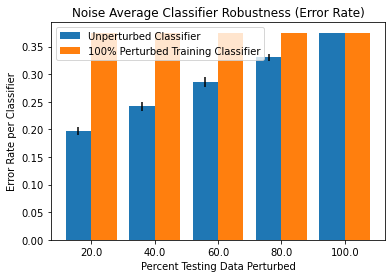

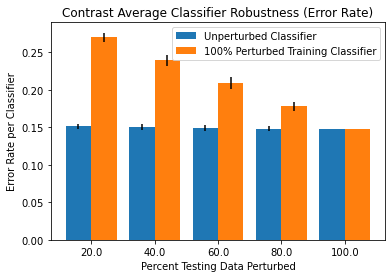

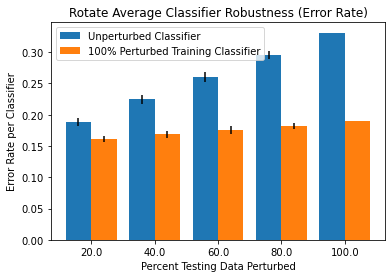

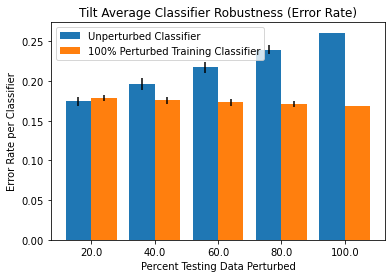

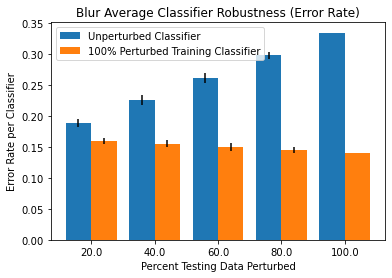

In [31]:
perturbs_capital   = ['Noise', 'Contrast', 'Rotate', 'Tilt', 'Blur']
for j in range(len(perturbs)):
    p = perturbs[j]
    c = perturbs_capital[j]
    plt.figure()
    
    r = np.arange(5)
    
    axs[j].plot()
    plt.bar(r - 0.2, np.mean(clean_avgs[p], axis = 0) , 0.4, yerr = np.mean(clean_stds[p], axis = 0),label = 'Unperturbed Classifier')
    plt.bar(r + 0.2, np.mean(pert_avgs[p], axis = 0), 0.4, yerr = np.mean(pert_stds[p], axis = 0),label = '100% Perturbed Training Classifier')
    plt.xticks(ticks=r, labels= np.array(proportion)*100)  
    plt.xlabel("Percent Testing Data Perturbed")
    plt.ylabel("Error Rate per Classifier")
    plt.title(str(c)+ " Average Classifier Robustness (Error Rate)")
    plt.legend()
    plt.savefig('XRAY3_Average'+str(c)+'_Err_BMES.png')

In [49]:
accs_pert2  = []
accs_pert3  = []
for m in range(len(pmodel_list)):
    acc_of_pert_clf2 = {}
    acc_of_pert_clf3 = {}
    
    pmodels = pmodel_list[m]
    omodel = omodel_list[m]
    for i in range(len(perturbs)):
        results_perturbed2 = np.zeros((num_iter, len(proportion)))
        results_perturbed3 = np.zeros((num_iter, len(proportion)))
        
        perturb_source = perturbs[i]
        
        for j in range(len(proportion)):
            p = proportion[j]
            

            for k in tqdm(range(num_iter)):

                pert_preds2 = pmodels[perturb_source][2].predict(mc_sets[perturb_source][j][k]).round()
                pert_preds3  = pmodels[perturb_source][4].predict(mc_sets[perturb_source][j][k]).round()
            
                err_2 = 1-accuracy_score(y_test, pert_preds2)
                err_3 = 1-accuracy_score(y_test, pert_preds3)
        
                results_perturbed2[k,j] = err_2
                results_perturbed3[k,j] = err_3
            
        acc_of_pert_clf2[perturb_source] = results_perturbed2
        acc_of_pert_clf3[perturb_source]  = results_perturbed3
    accs_pert2.append(acc_of_pert_clf2)
    accs_pert3.append(acc_of_pert_clf3)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [03:30<00:00,  1.05s/it]


<ipython-input-97-f572731120da>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


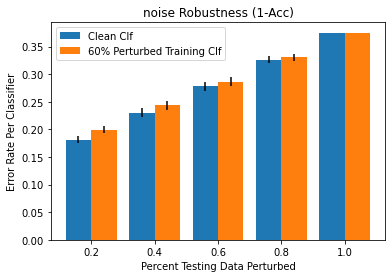

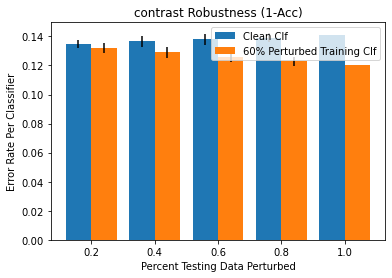

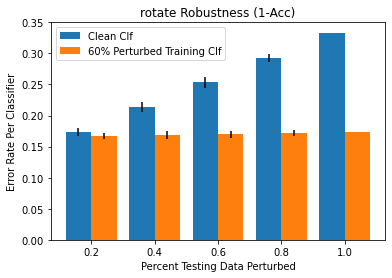

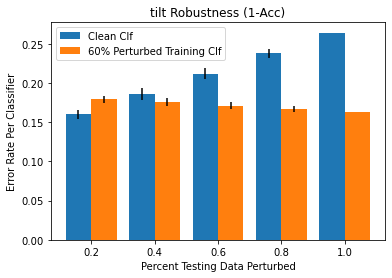

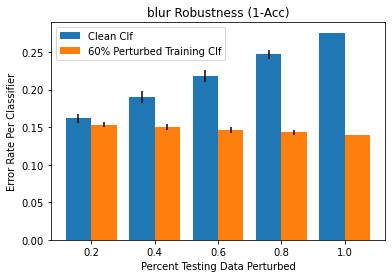

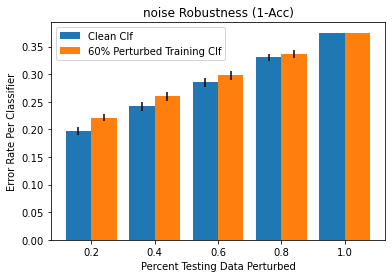

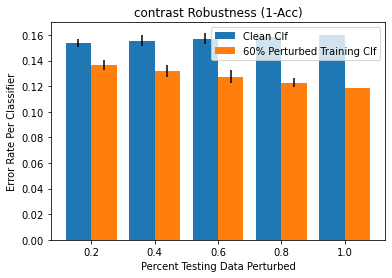

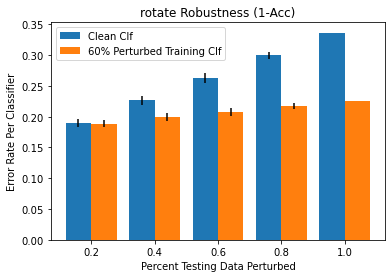

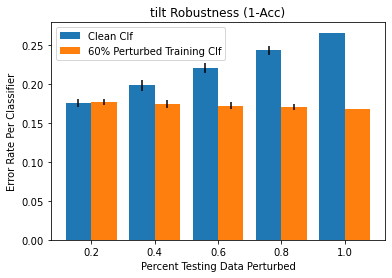

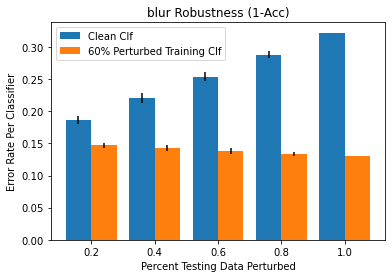

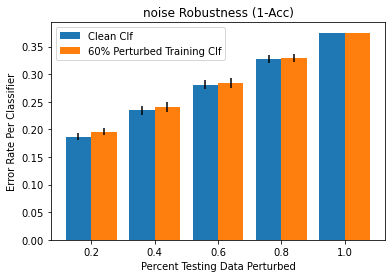

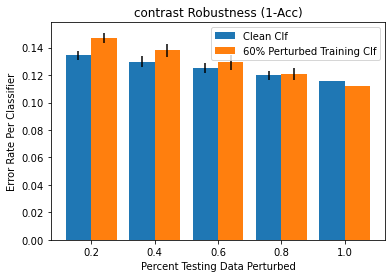

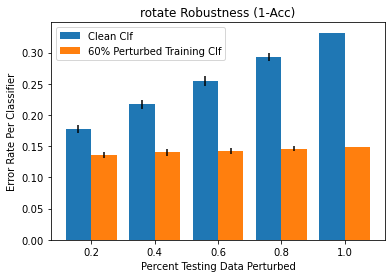

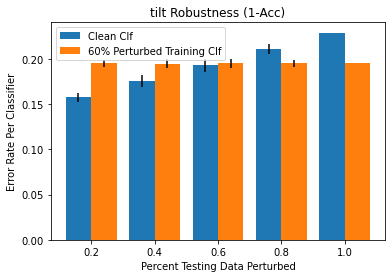

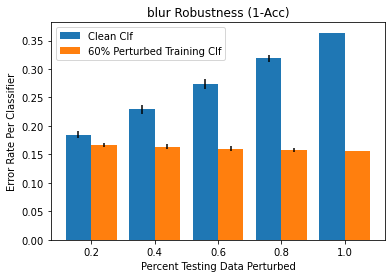

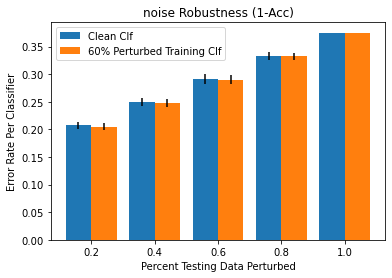

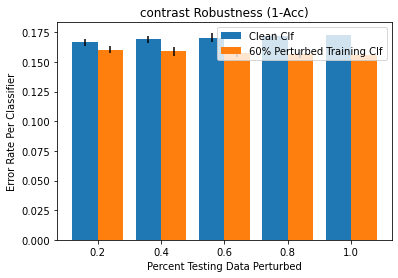

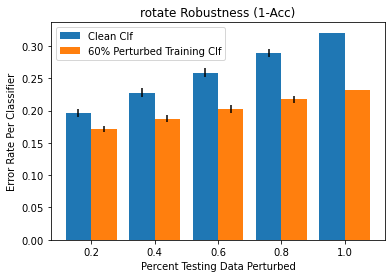

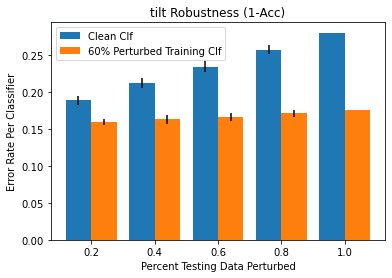

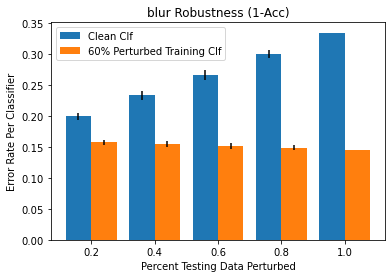

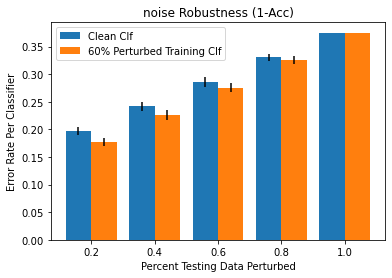

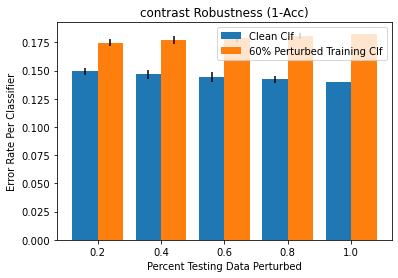

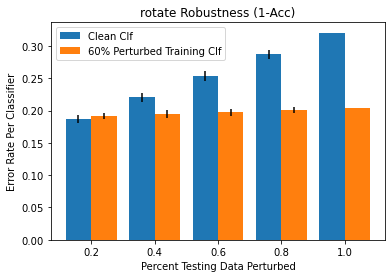

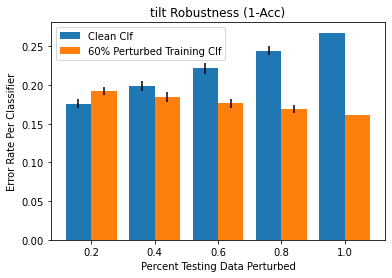

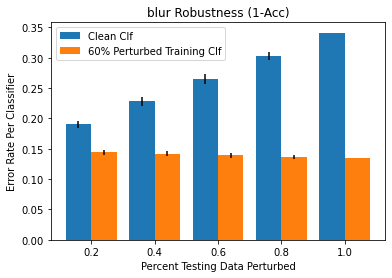

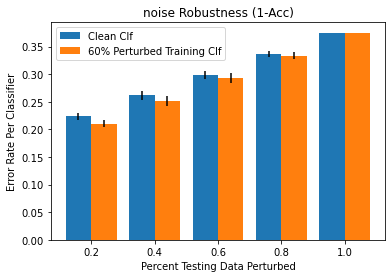

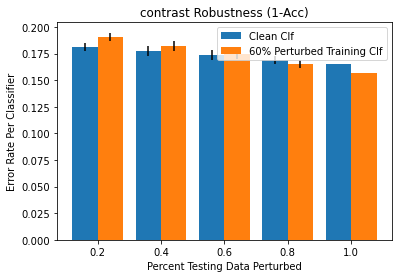

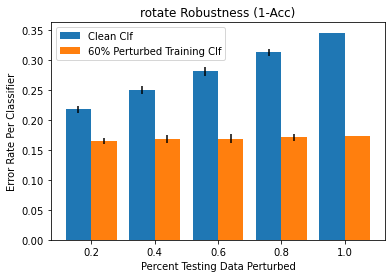

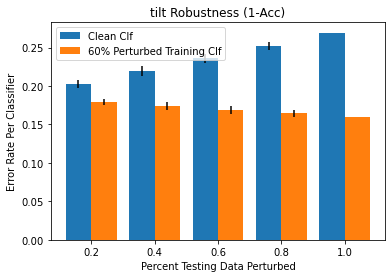

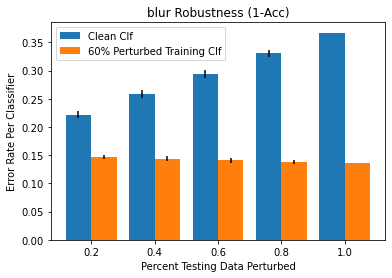

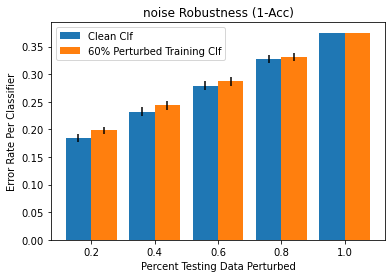

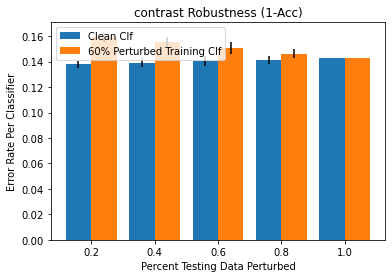

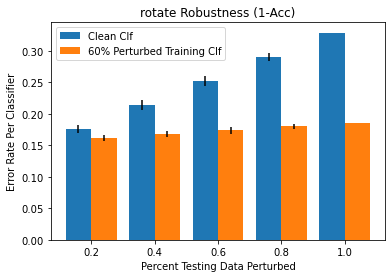

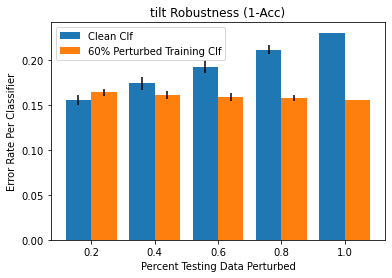

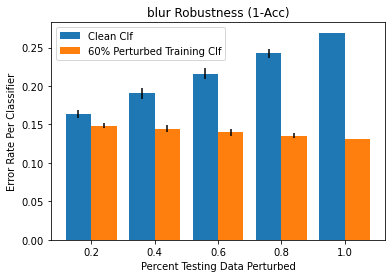

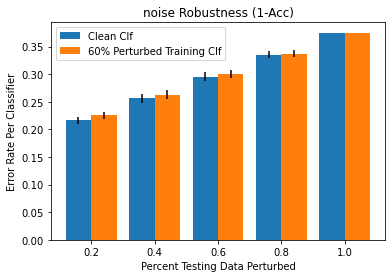

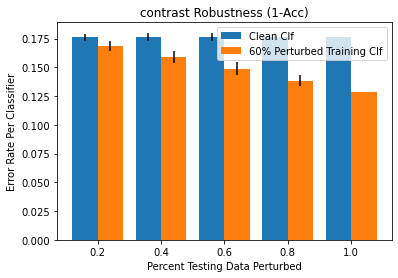

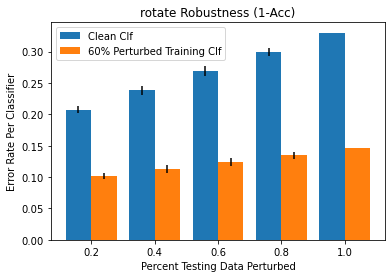

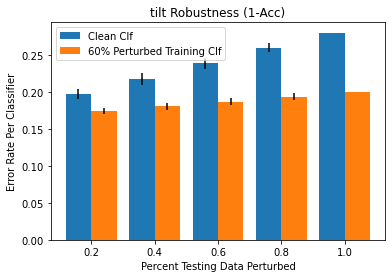

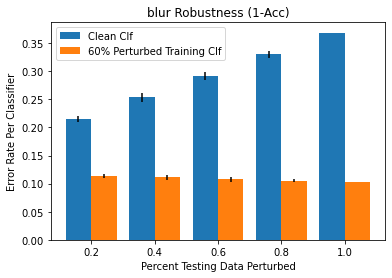

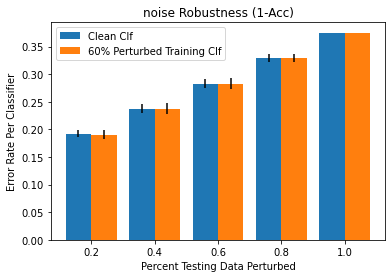

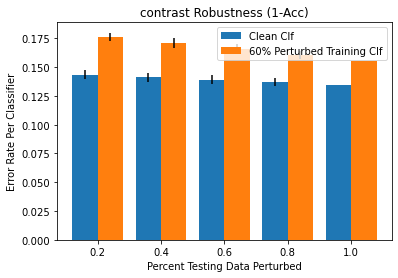

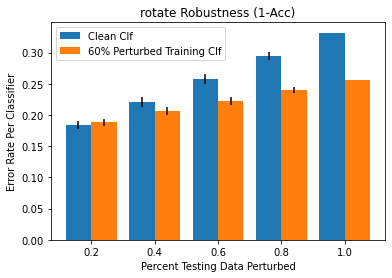

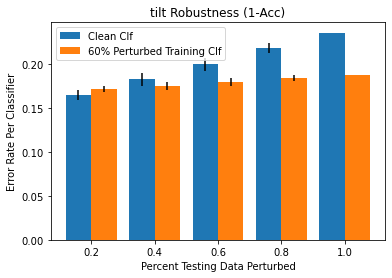

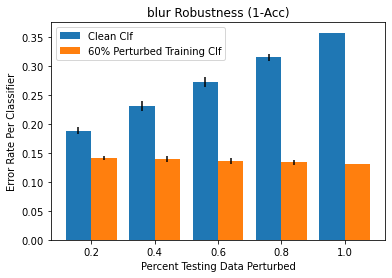

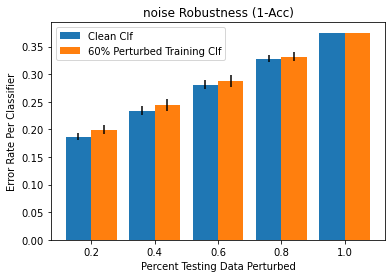

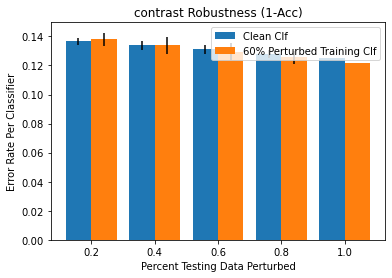

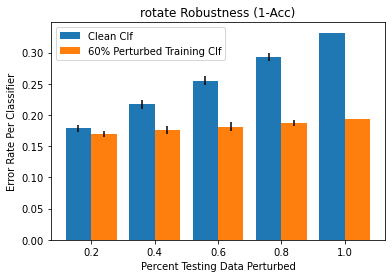

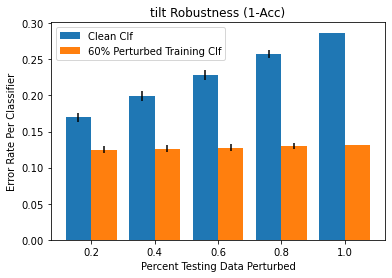

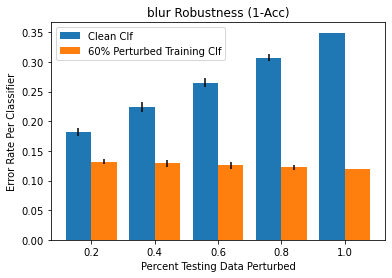

In [97]:

for i in range(len(accs_clean)):
    model_number = i
    for j in range(len(perturbs)):
        p = perturbs[j]
        plt.figure()
    
        r = np.arange(5)
    

        plt.bar(r - 0.2, np.mean(accs_clean[i][p], axis = 0), 0.4, yerr = np.std(accs_clean[i][p], axis = 0),label = 'Clean Clf')
        plt.bar(r + 0.2, np.mean(accs_pert2[i][p], axis = 0), 0.4, yerr = np.std(accs_pert2[i][p], axis = 0),label = '60% Perturbed Training Clf')
        plt.xticks(ticks=r, labels=proportion)  
        plt.xlabel("Percent Testing Data Perturbed")
        plt.ylabel("Error Rate Per Classifier")
        plt.title(str(p)+ " Robustness (1-Acc)")
        plt.legend()
        plt.savefig('XRAY1_'+str(model_number)+str(p)+'_Err_ReRun_Capital.png')

In [100]:
clean_avgs = {}
pert_avgs = {}
clean_stds = {}
pert_stds  = {}
for j in perturbs:
    clean_avgs[j] = np.zeros((10,5))
    pert_avgs[j]  = np.zeros((10,5))
    clean_stds[j] = np.zeros((10,5))
    pert_stds[j]  = np.zeros((10,5))
    for i in range(len(accs_clean)):
        clean_avgs[j][i,:] = np.mean(accs_clean[i][j], axis = 0)
        pert_avgs[j][i,:] = np.mean(accs_pert3[i][j], axis = 0)
        clean_stds[j][i,:] = np.std(accs_clean[i][j], axis = 0)
        pert_stds[j][i,:]  = np.std(accs_pert3[i][j], axis = 0)

In [71]:
def plot(img, fig_size = (2,2), save = ''):
    plt.figure(figsize = fig_size)
    plt.imshow(img, cmap = "gray")
    plt.axis('off')
    if save != '':
        plt.savefig(save)
    plt.show()

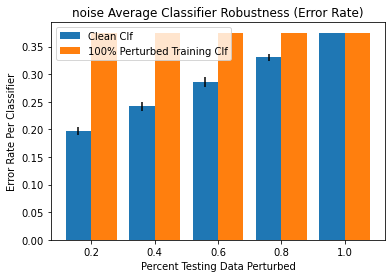

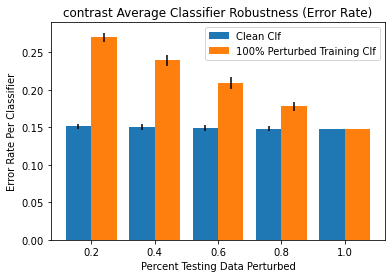

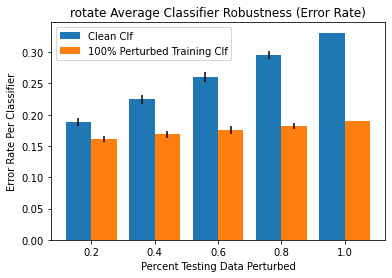

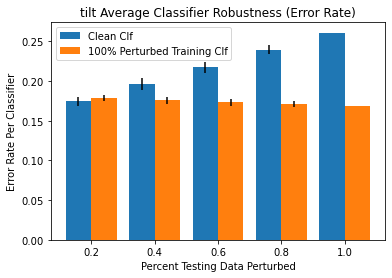

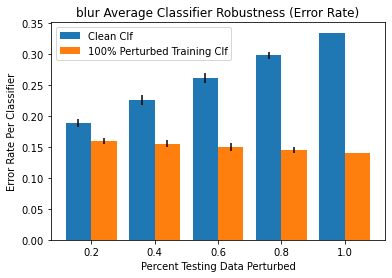

In [101]:
perturbs_capital   = ['Noise', 'Contrast', 'Rotate', 'Tilt', 'Blur']
for j in range(len(perturbs)):
    p = perturbs[j]
    c = perturbs_capital[j]
    plt.figure()
    
    r = np.arange(5)
    

    plt.bar(r - 0.2, np.mean(clean_avgs[p], axis = 0) , 0.4, yerr = np.mean(clean_stds[p], axis = 0),label = 'Unperturbed Classifier')
    plt.bar(r + 0.2, np.mean(pert_avgs[p], axis = 0), 0.4, yerr = np.mean(pert_stds[p], axis = 0),label = '20% Perturbed Training Classifier')
    plt.xticks(ticks=r, labels= np.array(proportion)*100)  
    plt.xlabel("Percent Testing Data Perturbed")
    plt.ylabel("Error Rate per Classifier")
    plt.title(str(c)+ " Average Classifier Robustness (Error Rate)")
    plt.legend()
    plt.savefig('XRAY1_Average'+str(j)+'_Err_BMES.png')

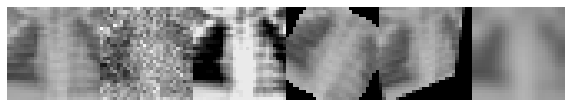

In [72]:
a = gaussian_noise(img, 0.1)
b = contrast(img, 3)
pic = rotate(img, deg = 45)
c = np.array(pic.getdata()).reshape(pic.size[0], pic.size[1])
pic = tilt(img, deg = 45)
d = np.array(pic.getdata()).reshape(pic.size[0], pic.size[1])
e = defocus_blur(img)
m = np.hstack([img, a*255,b,c,d,e])
cv2.imshow("Collage",m)
l1 = ['Original Image, Gaussian Noise, Contrast, Rotate, Tilt, Blur']
plot(m, fig_size = (10,13), save = 'Collage.png')